# Timeseries NN

In [21]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
covid_data = pd.read_csv('COVID-19-complete-07-aug.csv')
covid_data = covid_data[covid_data['Country/Region'] == 'Canada']
covid_data.head()

,Unnamed: 0,Country/Region,Date,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
32,32,Canada,2020-01-22,0,0,0.0,0.0,0,0,0
218,218,Canada,2020-01-23,0,0,0.0,0.0,0,0,0
404,404,Canada,2020-01-24,0,0,0.0,0.0,0,0,0
590,590,Canada,2020-01-25,0,0,0.0,0.0,0,0,0
776,776,Canada,2020-01-26,1,0,0.0,1.0,1,0,0


In [3]:
series = covid_data.set_index('Date')['New cases']

In [4]:
series.head(), series.min(), series.max(), series.shape

(Date
 2020-01-22    0
 2020-01-23    0
 2020-01-24    0
 2020-01-25    0
 2020-01-26    1
 Name: New cases, dtype: int64,
 0,
 2778,
 (198,))

## Data Processing

In [5]:
test_points = 21
train_data = series[:-test_points].to_numpy()
test_data = series[-test_points:].to_numpy()
print(len(train_data), len(test_data), len(train_data)+len(test_data), series.shape)

177 21 198 (198,)


In [6]:
# 189 = 3 * 3 * * 7 * 3
series.shape[0] % 21, train_data.shape[0]%21, train_data.shape[0]/21

(9, 9, 8.428571428571429)

In [7]:
7*21

147

In [8]:
# scaling values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normal = scaler.fit_transform(train_data.reshape(-1,1))

In [9]:
train_tensor = torch.FloatTensor(train_data_normal.reshape(1,-1)[0])
train_tensor

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.9993, -1.0000, -0.9993, -1.0000,
        -1.0000, -0.9986, -1.0000, -1.0000, -1.0000, -1.0000, -0.9993, -1.0000,
        -0.9986, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -0.9993, -1.0000, -1.0000, -1.0000, -0.9993, -1.0000,
        -1.0000, -0.9993, -0.9993, -1.0000, -0.9986, -0.9993, -0.9957, -0.9971,
        -0.9978, -0.9978, -0.9978, -0.9971, -0.9914, -0.9964, -0.9928, -0.9906,
        -0.9986, -0.9791, -0.9935, -0.9467, -0.9964, -0.9611, -0.8826, -0.9590,
        -0.8719, -0.8970, -0.8978, -0.7595, -0.8639, -0.5544, -0.4946, -0.6681,
        -0.4305, -0.5392, -0.3564, -0.4932, -0.1951, -0.1872, -0.2563,  0.2412,
        -0.1699, -0.6105,  1.0000, -0.4190, -0.0576, -0.0864,  0.0893,  0.0115,
        -0.0950, -0.2923, -0.0058, -0.0245, -0.1548,  0.8719,  0.4435,  0.1102,
        -0.0806,  0.4579,  0.2556,  0.6278,  0.1778,  0.1663,  0.0454,  0.1965,
         0.1397,  0.1044,  0.2347,  0.14

In [10]:
train_window = 21

training_seq = []
for i in range(train_window+1, len(train_tensor)):
    train_seq = train_tensor[i-train_window-1:i]
    train_label = train_tensor[i]
    training_seq.append((train_seq, train_label))
    
training_seq[:5], training_seq[-1]

([(tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.9993, -1.0000, -0.9993, -1.0000,
           -1.0000, -0.9986, -1.0000, -1.0000, -1.0000, -1.0000, -0.9993, -1.0000,
           -0.9986, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]),
   tensor(-1.)),
  (tensor([-1.0000, -1.0000, -1.0000, -0.9993, -1.0000, -0.9993, -1.0000, -1.0000,
           -0.9986, -1.0000, -1.0000, -1.0000, -1.0000, -0.9993, -1.0000, -0.9986,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]),
   tensor(-1.)),
  (tensor([-1.0000, -1.0000, -0.9993, -1.0000, -0.9993, -1.0000, -1.0000, -0.9986,
           -1.0000, -1.0000, -1.0000, -1.0000, -0.9993, -1.0000, -0.9986, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]),
   tensor(-1.)),
  (tensor([-1.0000, -0.9993, -1.0000, -0.9993, -1.0000, -1.0000, -0.9986, -1.0000,
           -1.0000, -1.0000, -1.0000, -0.9993, -1.0000, -0.9986, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000]),
   tensor(-1.)),


In [11]:
len(training_seq)

155

## Model Training

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [13]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [15]:
epochs = 1000

for i in range(epochs):
    for seq, labels in training_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

/opt/anaconda3/envs/newenv/lib/python3.8/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 0.02387876
epoch:  26 loss: 0.00027907
epoch:  51 loss: 0.00326288
epoch:  76 loss: 0.00101651
epoch: 101 loss: 0.00009851
epoch: 126 loss: 0.00005027
epoch: 151 loss: 0.00119416
epoch: 176 loss: 0.00000361
epoch: 201 loss: 0.00012078
epoch: 226 loss: 0.00050235
epoch: 251 loss: 0.00062790
epoch: 276 loss: 0.00000173
epoch: 301 loss: 0.04153182
epoch: 326 loss: 0.00008055
epoch: 351 loss: 0.00000131
epoch: 376 loss: 0.00075348
epoch: 401 loss: 0.00549777
epoch: 426 loss: 0.00016892
epoch: 451 loss: 0.00069235
epoch: 476 loss: 0.00604520
epoch: 501 loss: 0.00000141
epoch: 526 loss: 0.00161525
epoch: 551 loss: 0.00100340
epoch: 576 loss: 0.00007968
epoch: 601 loss: 0.00007987
epoch: 626 loss: 0.00252963
epoch: 651 loss: 0.00042840
epoch: 676 loss: 0.00111032
epoch: 701 loss: 0.00005202
epoch: 726 loss: 0.00175899
epoch: 751 loss: 0.00001681
epoch: 776 loss: 0.00042356
epoch: 801 loss: 0.00009469
epoch: 826 loss: 0.00018817
epoch: 851 loss: 0.00034331
epoch: 876 loss: 0.0

## Predictions

In [16]:
model.eval()
num_future_preds = 21
test_inputs = train_tensor[-train_window:].tolist()
for i in range(num_future_preds):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
        
#new predictions
test_inputs[-num_future_preds:]

[-0.7489802241325378,
 -0.7758578062057495,
 -0.669914722442627,
 -0.798261284828186,
 -0.7338297367095947,
 -0.8694636821746826,
 -0.8123722672462463,
 -0.8602398633956909,
 -0.6440181732177734,
 -0.760844886302948,
 -0.7531960606575012,
 -0.8103803992271423,
 -0.7599161863327026,
 -0.7678914070129395,
 -0.7418215274810791,
 -0.794487476348877,
 -0.8009388446807861,
 -0.8575289845466614,
 -0.7969215512275696,
 -0.6670555472373962,
 -0.6285743117332458]

In [17]:
predictions = scaler.inverse_transform(np.array(test_inputs[-num_future_preds:]).reshape(-1,1))

In [19]:
predictions

array([[348.66646868],
       [311.33350718],
       [458.48845053],
       [280.21507537],
       [369.71049571],
       [181.31494546],
       [260.61492079],
       [194.12682974],
       [494.4587574 ],
       [332.18645293],
       [342.81067175],
       [263.38162547],
       [333.47641718],
       [322.39883566],
       [358.60989833],
       [285.45689535],
       [276.49594474],
       [197.89224046],
       [282.07596534],
       [462.45984489],
       [515.910281  ]])

In [32]:
plt.figure(figsize=(25,20))
import plotly.graph_objects as go

# fig = px.line(series, x=series.index, y=series.values, title='Daily new Cases in Canada')
# fig = px.line(series, x=series.index[-test_points:], y=predictions, title='predictions')
# fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=series.index, y=series.values, name="actual",
                    line_shape='linear'))
fig.add_trace(go.Scatter(x=series.index[-test_points:], y=predictions, name="prediction",
                    line_shape='linear'))
fig.show()

<Figure size 1800x1440 with 0 Axes>

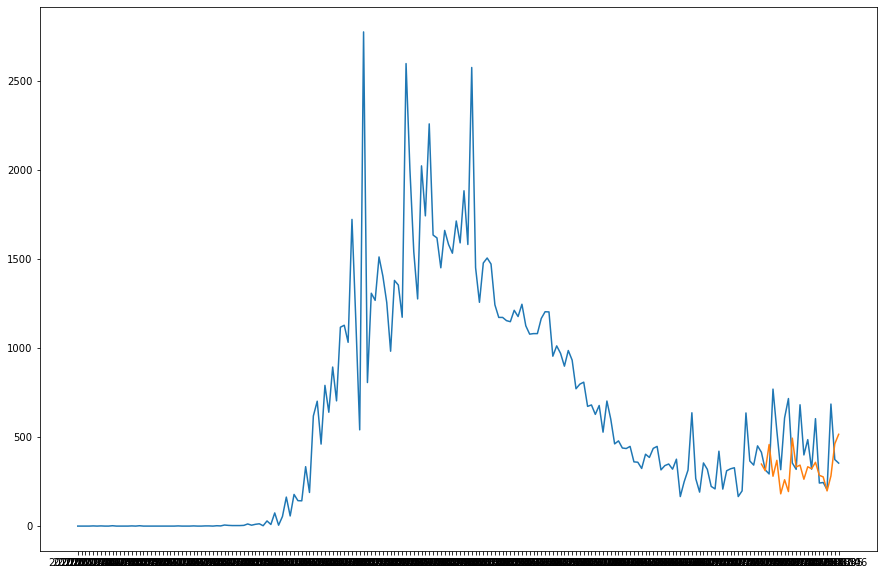

In [26]:
plt.figure(figsize=(15,10))
plt.plot(series.index, series.values)
plt.plot(series.index[-test_points:], predictions)
plt.show()